In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange

from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../RenderMan/Builds/LinuxMakefile/build')
vst_path = "../Dexed.so"
import librenderman as rm
import RenderPatches as rp
engine = rp.create_engine(vst_path)
import IPython.display as ipd

def play_audio(audio, rate=44100):
    ipd.display(ipd.Audio(audio, rate=rate))

generator = rm.PatchGenerator(engine)


In [2]:
n_bytes = 145
fname = "../data_extraction/presets_and_maxs.npz"

class PresetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
def load_data(fname):
    npzfile = np.load(fname)
    return npzfile[npzfile.files[0]], npzfile[npzfile.files[1]] # presets, maxs

def save_preset(fname, preset_data):
    s = ""
    for elt in preset_data:
        s += str(elt)+" "
    with open(fname, "w") as file:
        file.write(s)
        

In [23]:
data, maxs = load_data(fname)
audio = rp.render_patch(data[4], engine, override=True)
print(engine.get_plugin_parameter_size())
print(engine.get_plugin_parameters_description())
play_audio(audio)
print(data[0].shape)

155
  0: Cutoff
  1: Resonance
  2: Output
  3: MASTER TUNE ADJ
  4: ALGORITHM
  5: FEEDBACK
  6: OSC KEY SYNC
  7: LFO SPEED
  8: LFO DELAY
  9: LFO PM DEPTH
 10: LFO AM DEPTH
 11: LFO KEY SYNC
 12: LFO WAVE
 13: MIDDLE C
 14: P MODE SENS.
 15: PITCH EG RATE 1
 16: PITCH EG RATE 2
 17: PITCH EG RATE 3
 18: PITCH EG RATE 4
 19: PITCH EG LEVEL
 20: PITCH EG LEVEL
 21: PITCH EG LEVEL
 22: PITCH EG LEVEL
 23: OP1 EG RATE 1
 24: OP1 EG RATE 2
 25: OP1 EG RATE 3
 26: OP1 EG RATE 4
 27: OP1 EG LEVEL 1
 28: OP1 EG LEVEL 2
 29: OP1 EG LEVEL 3
 30: OP1 EG LEVEL 4
 31: OP1 OUTPUT LEVE
 32: OP1 MODE
 33: OP1 F COARSE
 34: OP1 F FINE
 35: OP1 OSC DETUNE
 36: OP1 BREAK POINT
 37: OP1 L SCALE DEP
 38: OP1 R SCALE DEP
 39: OP1 L KEY SCALE
 40: OP1 R KEY SCALE
 41: OP1 RATE SCALIN
 42: OP1 A MOD SENS.
 43: OP1 KEY VELOCIT
 44: OP1 SWITCH
 45: OP2 EG RATE 1
 46: OP2 EG RATE 2
 47: OP2 EG RATE 3
 48: OP2 EG RATE 4
 49: OP2 EG LEVEL 1
 50: OP2 EG LEVEL 2
 51: OP2 EG LEVEL 3
 52: OP2 EG LEVEL 4
 53: OP2 O

(145,)


In [3]:
def fc_layer(D_in, D_out):
    layers = ()
    layers += (nn.Linear(D_in, D_out),)
    #layers += (nn.BatchNorm1d(num_features=D_out))
    layers += (nn.LeakyReLU(0.05),)
    return nn.Sequential(*layers)    

class Coder(nn.Module) :
    def __init__(self, D_in, D_h_list, D_out, output_activation=None) :
        super(Coder,self).__init__()
        
        self.layers = ()
        
        for i in range(len(D_h_list)):
            self.layers += (fc_layer(D_in, D_h_list[i]),)
            D_in = D_h_list[i]
        
        self.layers += (nn.Linear(D_in, D_out),)
        
        assert output_activation is None or output_activation in ["sigmoid","LeakyReLU"]
        if output_activation == "sigmoid":
            print("sigmoid")
            self.layers += (nn.Sigmoid(),)
        elif output_activation == "LeakyReLU":
            self.layers += (nn.LeakyReLU(.05),)
            
        self.layers = nn.Sequential( *self.layers)
        print(self.layers)

    def forward(self,z):
        return self.layers(z)


class betaVAE(nn.Module) :
    def __init__(self, D_x, D_h, D_z, beta=1.0, use_cuda=True) :
        super(betaVAE,self).__init__()
        print("encoder")
        self.encoder = Coder(D_x, D_h, D_z*2, output_activation=None)
        print("decoder")
        self.decoder = Coder(D_z, D_h[::-1], D_x, output_activation="sigmoid")
        self.beta = beta
        self.use_cuda = use_cuda

        if self.use_cuda :
            self = self.cuda()

    def reparameterize(self, mu, log_var) :
        eps = torch.randn((mu.size()[0], mu.size()[1]))
        veps = Variable(eps)
        #veps = Variable( eps, requires_grad=False)
        if self.use_cuda:
            veps = veps.cuda()
        z = mu + veps * torch.exp(log_var/2)
        return z

    def forward(self,x) :
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)

        return out, mu, log_var





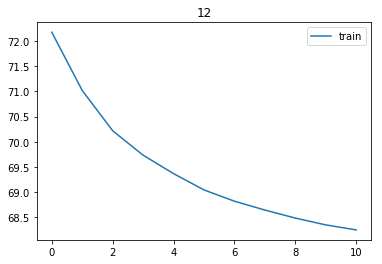

KeyboardInterrupt: 

In [4]:

# Model :
D_x = n_bytes
D_h = [800]
D_z = 20
use_cuda = False
beta = 1
vae = betaVAE(D_x, D_h, D_z, beta, use_cuda).float()

# Optim :
lr = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
batch_size = 400
test = False
plot_loss = True

# Data :
ds_proportions_bounds = (.7,.85,1)
data, maxs = load_data(fname)
n_data = len(data)
datasets = {}
datasets['train'] = PresetDataset(data[:int(n_data*ds_proportions_bounds[0])])
datasets['test'] = PresetDataset(data[int(n_data*ds_proportions_bounds[0]):int(n_data*ds_proportions_bounds[1])])
datasets['validate'] = PresetDataset(data[int(n_data*ds_proportions_bounds[1]):int(n_data*ds_proportions_bounds[2])])
print("Dataset sizes: "+str([k+":"+str(len(datasets[k])) for k in datasets.keys()]))


loaders = {k: DataLoader(dataset=datasets[k], batch_size=batch_size, shuffle=True) for k in datasets.keys()}

datasets['save_presets'] = PresetDataset(data[:int(n_data*ds_proportions_bounds[0])])
loaders['save_presets'] = DataLoader(dataset=datasets['save_presets'], batch_size=1, shuffle=False)


loss_history = {k:[] for k in ['train','test','validate']}

#for epoch in trange(1000, desc="epochs"):
for epoch in range(1000):
    
    
    loss_history['train'].append(0)
    loss_history['test'].append(0)
    
    for i, presets in enumerate(loaders['train']):
        
        optimizer.zero_grad()
        
        # Load data
        if use_cuda :
            presets = presets.cuda() 
        presets = presets.view(-1, D_x).float()
        
        # Forward + backward + optimize
        out, mu, log_var = vae(presets)
        reconst_loss = F.binary_cross_entropy(out, presets, reduction='sum')
        kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        total_loss = reconst_loss + vae.beta * kl_divergence
        loss_history['train'][-1] += total_loss
        
        # 
        total_loss.backward()
        optimizer.step()
        
    loss_history['train'][-1] /= i*batch_size
    
    
    if test:
        for i, presets in enumerate(loaders['test']):
            
            # Load data
            if use_cuda :
                presets = presets.cuda() 
            presets = presets.view(-1, D_x).float()
            
            # Forward
            out, mu, log_var = vae(presets)
            reconst_loss = F.binary_cross_entropy(out, presets, reduction='sum')
            kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
            total_loss = reconst_loss + vae.beta * kl_divergence
            loss_history['test'][-1] += total_loss

        loss_history['test'][-1] /= i*batch_size
        
    if plot_loss:
        clear_output()
        plt.title(str(epoch))
        plt.plot(loss_history['train'][2:], label='train')
        if test:
            plt.plot(loss_history['test'][2:], label='test')
        plt.legend()
        plt.show()
    
    
    
        




In [10]:

for i, presets in enumerate(loaders['save_presets']):
    if i>2:
        break
    if use_cuda :
        presets = presets.cuda() 
    presets = presets.view(-1, D_x).float()
    out, mu, log_var = vae(presets)
    
    patch_data = np.array(presets[0], dtype=float)
    audio = rp.render_patch(patch_data, engine, override=False)
    play_audio(audio)
    
    patch_data = np.array(out.detach()[0], dtype=float)
    audio = rp.render_patch(patch_data, engine, override=False)
    play_audio(audio)
    
    print('\n')



In [ ]:
play_audio(audio)